# visualization of training and testinng

## visualization of training process

In [1]:
import argparse
import pickle

checkpoint_dir = './checkpoints'
#load argparse from pkl
with open(checkpoint_dir + '/args.pkl', 'rb') as f:
    args = pickle.load(f)

for arg in vars(args):
    print(f"{arg:<30}: {getattr(args, arg)}")



city                          : boston
simulation_num                : 2000000
test_simulation_num           : 1000
total_trajectories            : 1
capacity_scale                : 10
weight_quantization_scale     : None
max_connection                : 3
train_data_dir                : ./data/
test_data_dir                 : ./data_test/
use_given_data                : True
batch_size                    : 512
test_size                     : 500
path_num                      : 1
block_size                    : 50
special_mask_value            : 0.01
n_embd                        : 64
n_head                        : 16
n_layer                       : 8
dropout                       : 0.0
use_adj_table                 : True
max_iters                     : 200000
learning_rate                 : 0.1
lr_drop_rate                  : 0.5
eval_freq                     : 100
save_freq                     : 5
device                        : cuda:3
load_dir                      : ./checkpoints/


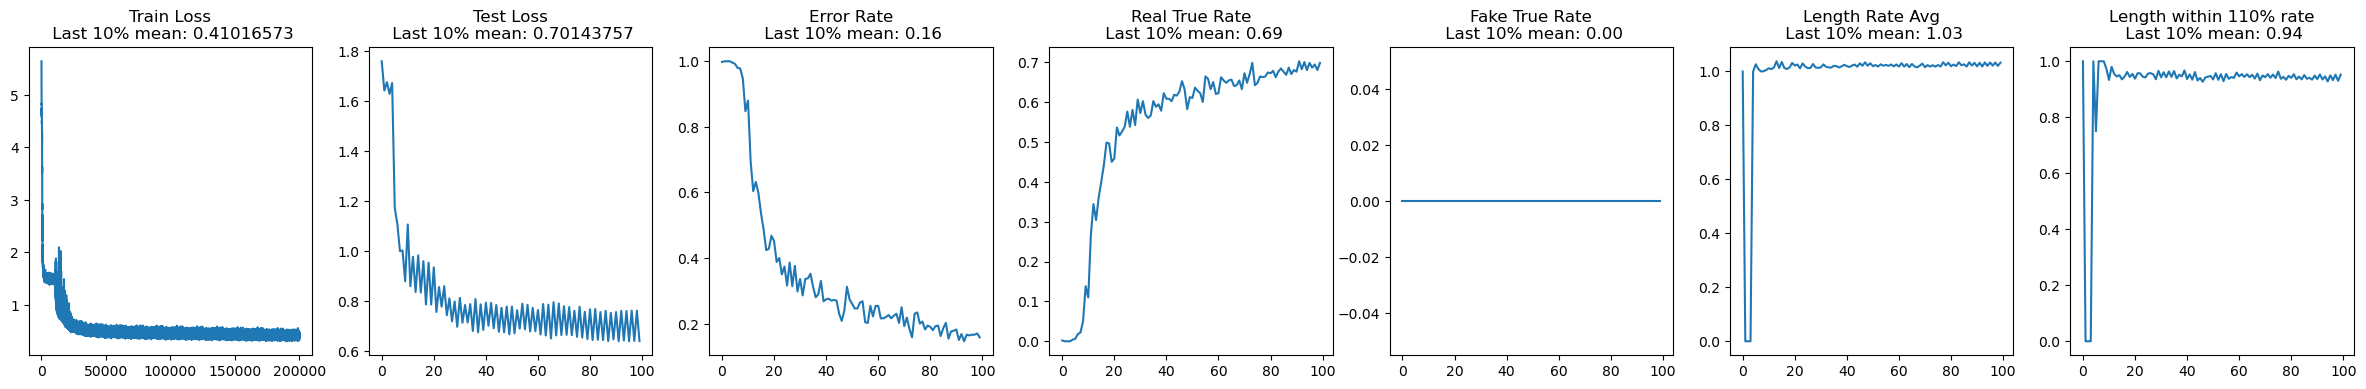

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

log_dir = './checkpoints'

# load the logger
with open(log_dir + '/logger_train_loss.pkl', 'rb') as f:
    logger_train_loss = pickle.load(f)
with open(log_dir + '/logger_test_loss.pkl', 'rb') as f:
    logger_test_loss = pickle.load(f)
with open(log_dir + '/logger_test_error_rate.pkl', 'rb') as f:
    logger_test_error_rate = pickle.load(f)
with open(log_dir + '/logger_test_real_true_rate.pkl', 'rb') as f:
    logger_test_real_true_rate = pickle.load(f)
with open(log_dir + '/logger_test_fake_true_rate.pkl', 'rb') as f:
    logger_test_fake_true_rate = pickle.load(f)
with open(log_dir + '/logger_test_length_rate_avg.pkl', 'rb') as f:
    logger_test_length_rate_avg = pickle.load(f)
with open(log_dir + '/logger_test_leng_10_rate.pkl', 'rb') as f:
    logger_test_leng_10_rate = pickle.load(f)


# plot the logger curves

visualization_num = int(len(logger_test_loss)*0.1)

plt.figure(figsize=(30, 4))
plt.subplot(1,7,1)
plt.plot(logger_train_loss)
train_loss_last = np.mean(logger_train_loss[-visualization_num:])
plt.title('Train Loss\n Last 10% mean: {:.8f}'.format(train_loss_last))

plt.subplot(1,7,2)
plt.plot(logger_test_loss)
test_loss_last = np.mean(logger_test_loss[-visualization_num:])
plt.title('Test Loss\n Last 10% mean: {:.8f}'.format(test_loss_last))

plt.subplot(1,7,3)
plt.plot(logger_test_error_rate)
error_rate_last = np.mean(logger_test_error_rate[-visualization_num:])
plt.title('Error Rate\n Last 10% mean: {:.2f}'.format(error_rate_last))

plt.subplot(1,7,4)
plt.plot(logger_test_real_true_rate)
real_true_rate_last = np.mean(logger_test_real_true_rate[-visualization_num:])
plt.title('Real True Rate\n Last 10% mean: {:.2f}'.format(real_true_rate_last))

plt.subplot(1,7,5)
plt.plot(logger_test_fake_true_rate)
fake_true_rate_last = np.mean(logger_test_fake_true_rate[-visualization_num:])
plt.title('Fake True Rate\n Last 10% mean: {:.2f}'.format(fake_true_rate_last))

plt.subplot(1,7,6)
plt.plot(logger_test_length_rate_avg)
length_rate_avg_last = np.mean(logger_test_length_rate_avg[-visualization_num:])
plt.title('Length Rate Avg\n Last 10% mean: {:.2f}'.format(length_rate_avg_last))

plt.subplot(1,7,7)
plt.plot(logger_test_leng_10_rate)
len_10_rate_last = np.mean(logger_test_leng_10_rate[-visualization_num:])
plt.title('Length within 110% rate\n Last 10% mean: {:.2f}'.format(len_10_rate_last))

plt.show()

## visualization of testing new fastest trajectories

### load model

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import networkx as nx

from utils import transfer_graph, transfer_table_to_matrix
from model import no_diffusion_model
from data_loader import data_loader

device = 'cuda:0'

# load model
i = 200000
checkpoint_dir = './checkpoints'
vocab_size = 242
n_embd, n_embd, n_layer, n_head, block_size, dropout, use_adj_table = args.n_embd, args.n_embd, args.n_layer, args.n_head, args.block_size, args.dropout, args.use_adj_table
model= no_diffusion_model(vocab_size, n_embd, n_embd, n_layer, n_head, block_size, dropout, weight_quantization_scale = None, use_adj_table=use_adj_table, use_ne=True, use_ge=True, use_agent_mask=False, norm_position='prenorm', device=device)
model.load_state_dict(torch.load(checkpoint_dir + '/complete_model_{}.pth'.format(i)).state_dict())
model.to(device)
model = model.eval()

### compare time

In [14]:
from utils import correct_pred, correct_pred_tensor

# load data
test_num = 2500
total_trajectories = 1
loader = data_loader(simulation_num=500,use_given_data= False,block_size=50)
test_trajectory, test_adj_table, test_condition, special_mask = loader.generate_batch(test_num, total_trajectories)

adj_matrix = [transfer_table_to_matrix(table) for table in test_adj_table]
adj_matrix = np.array(adj_matrix)
adj_matrix_tensor = torch.tensor(adj_matrix).to(device)
test_condition_tensor = test_condition.to(device)
test_adj_table_tensor = test_adj_table.to(device)

test_trajectory = test_trajectory.cpu().numpy().astype(np.int32)
test_adj_table = test_adj_table.cpu().numpy()
test_condition = test_condition.cpu().numpy()

# model forward
start_time = time.time()
with torch.no_grad():
    # logits = model.test(test_condition, test_adj_table)
    logits, _ = model(test_condition_tensor, test_adj_table_tensor)
    model_time = time.time()
    # del model
    logits = logits.cpu().numpy()
    predic_trajectory = np.argmax(logits, axis=-1)
    # predic_trajectory = torch.argmax(logits, dim=-1)
    transfer_time = time.time()
for i in range(test_num):
    for j in range(total_trajectories):
        predic_trajectory[i,j] = correct_pred(predic_trajectory[i,j], logits[i,j], test_condition[i,j],adj_matrix[i])
        # predic_trajectory[i,j] = correct_pred_tensor(predic_trajectory[i,j], logits[i,j], test_condition_tensor[i,j],adj_matrix_tensor[i])
correct_time = time.time()
print('Model Time:',model_time-start_time, 'Transfer Time:',transfer_time-model_time, 'Correct Time:',correct_time-transfer_time)
# predic_trajectory = predic_trajectory.cpu().numpy().astype(np.int32)

# dijkstra
time_len = 0
for i in range(test_num):
    for j in range(total_trajectories):
        G = transfer_graph(test_adj_table[i])
        start = test_condition[i,j,0]
        end = test_condition[i,j,1]
        start_time = time.time()
        # nx.dijkstra_path_length(G, start-1, end-1, weight='weight')
        nx.shortest_path(G, start-1, end-1, weight='weight')
        time_len += time.time()-start_time
print('Dijkstra Time:', time_len)

Model Time: 0.01399087905883789 Transfer Time: 1.796086072921753 Correct Time: 0.08471298217773438
Dijkstra Time: 0.5034599304199219


### print trajectory

In [15]:
# print the trajectory
from utils import print_trajectory, test_functions

print('Without correction:')
error_rate, real_true_rate, fake_true_rate, length_rate_avg, len_10_rate = test_functions(np.argmax(logits, axis=-1), test_trajectory, test_adj_table)
print(f'error rate: {error_rate:.2f}, real true rate: {real_true_rate:.2f}, fake true rate: {fake_true_rate:.2f}, length rate avg: {length_rate_avg:.2f}, length within 110% rate: {len_10_rate:.2f}')
print("With Correction:")
error_rate, real_true_rate, fake_true_rate, length_rate_avg, len_10_rate = test_functions(predic_trajectory, test_trajectory, test_adj_table)
print(f'error rate: {error_rate:.2f}, real true rate: {real_true_rate:.2f}, fake true rate: {fake_true_rate:.2f}, length rate avg: {length_rate_avg:.2f}, length within 110% rate: {len_10_rate:.2f}')

print(test_trajectory.shape)
print_trajectory(predic_trajectory, test_trajectory)

Without correction:
error rate: 0.17, real true rate: 0.71, fake true rate: 0.00, length rate avg: 1.01, length within 110% rate: 0.96
With Correction:
error rate: 0.04, real true rate: 0.73, fake true rate: 0.00, length rate avg: 1.04, length within 110% rate: 0.90
(2500, 1, 50)
weighted graph 1  , pred 1  : [200 174  85 173 184  89  90 172   8 169 170 171   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
weighted graph 1  , true 1  : [200 174  85 173 184  89  90 172   8 169 170 171   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
weighted graph 2  , pred 1  : [ 39  40  44  45  94 229 171 172  42 124  47  46   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
weighted graph 2 

### plot trajectory

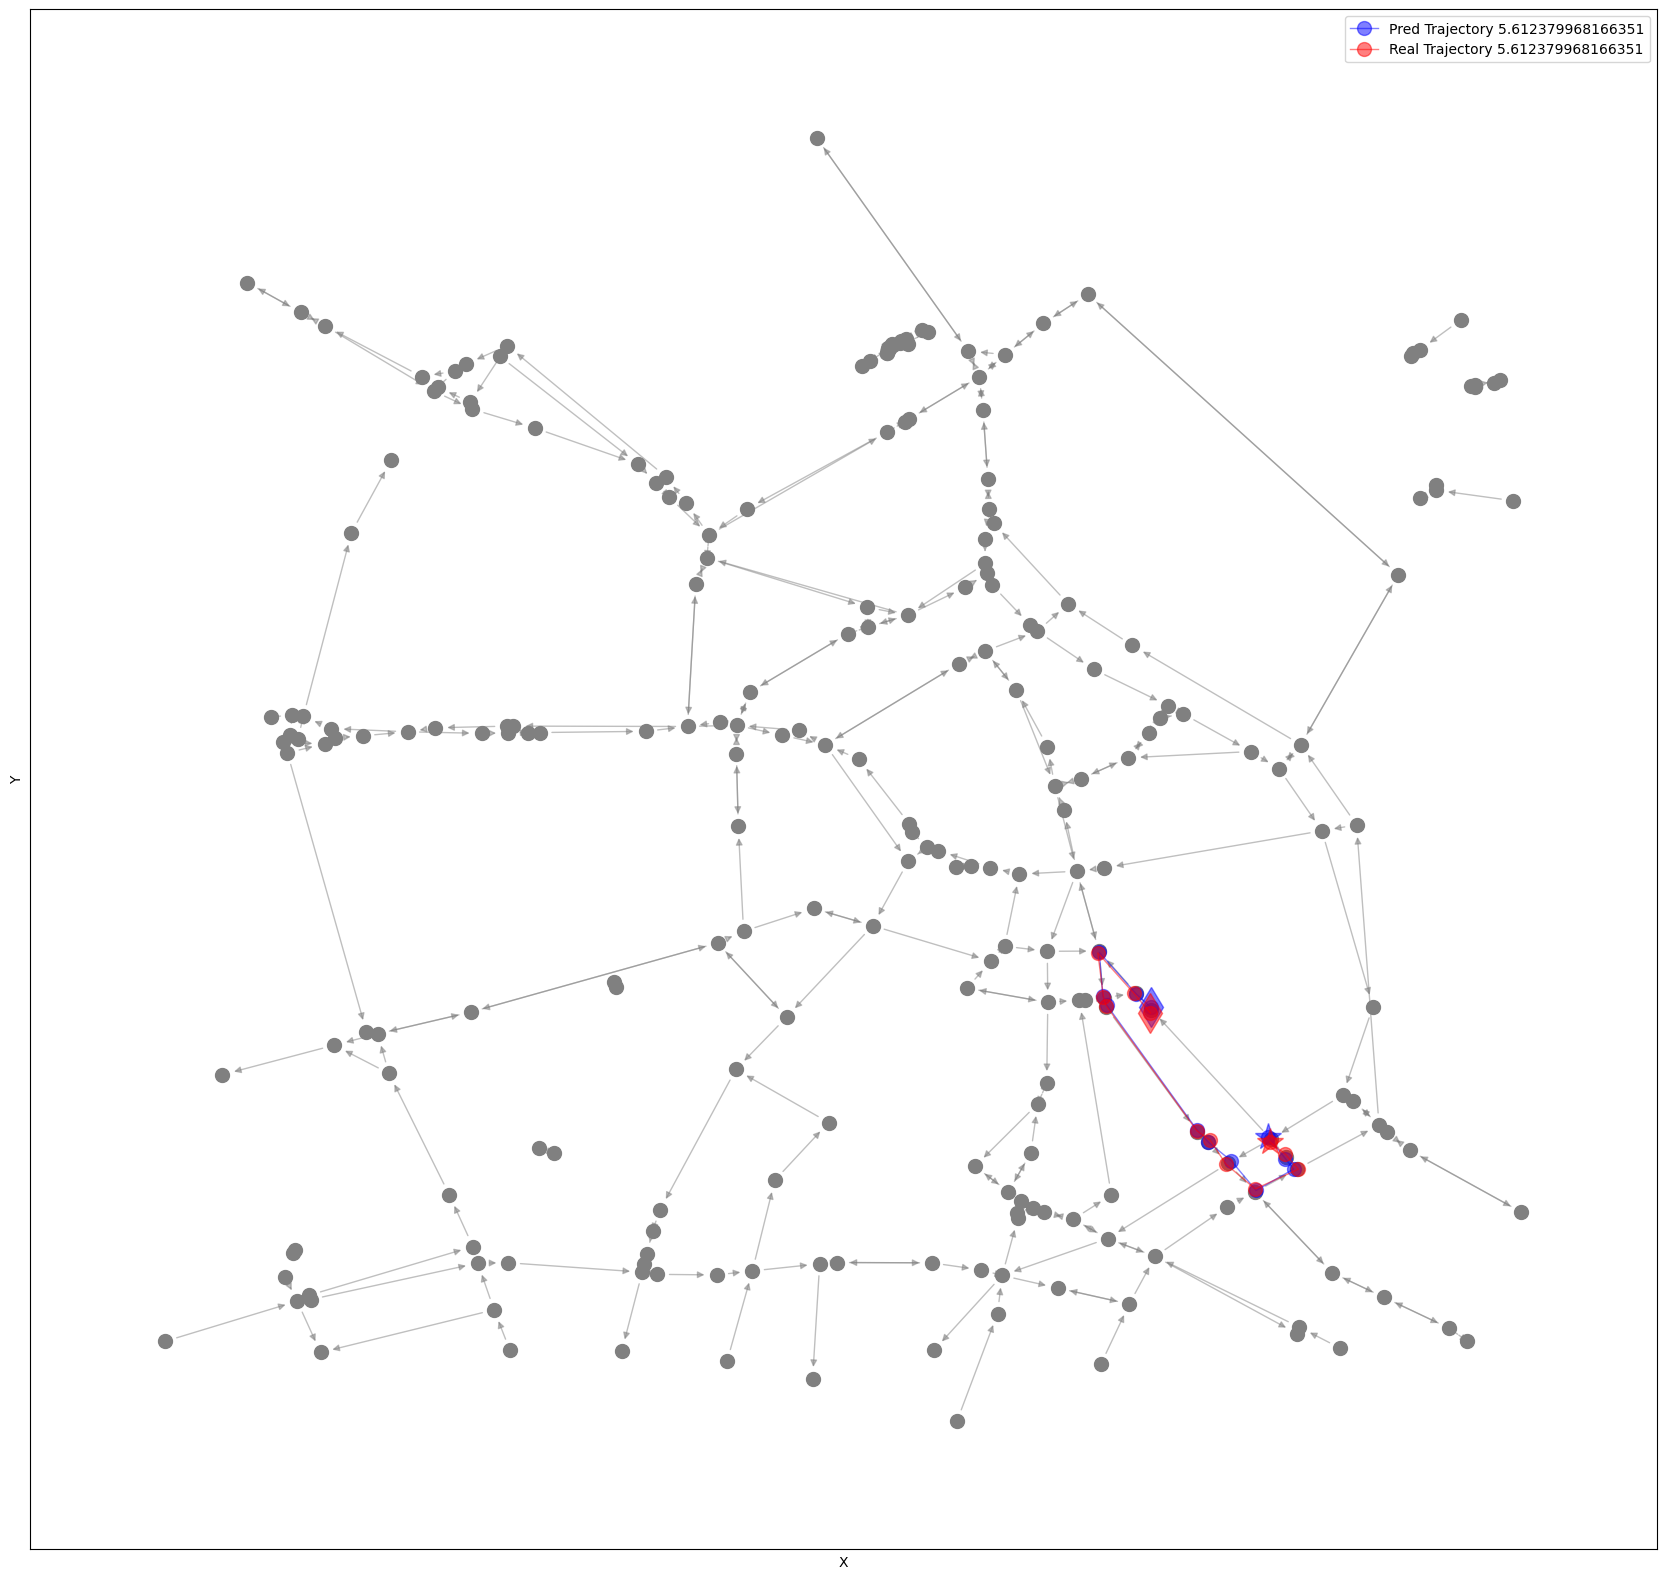

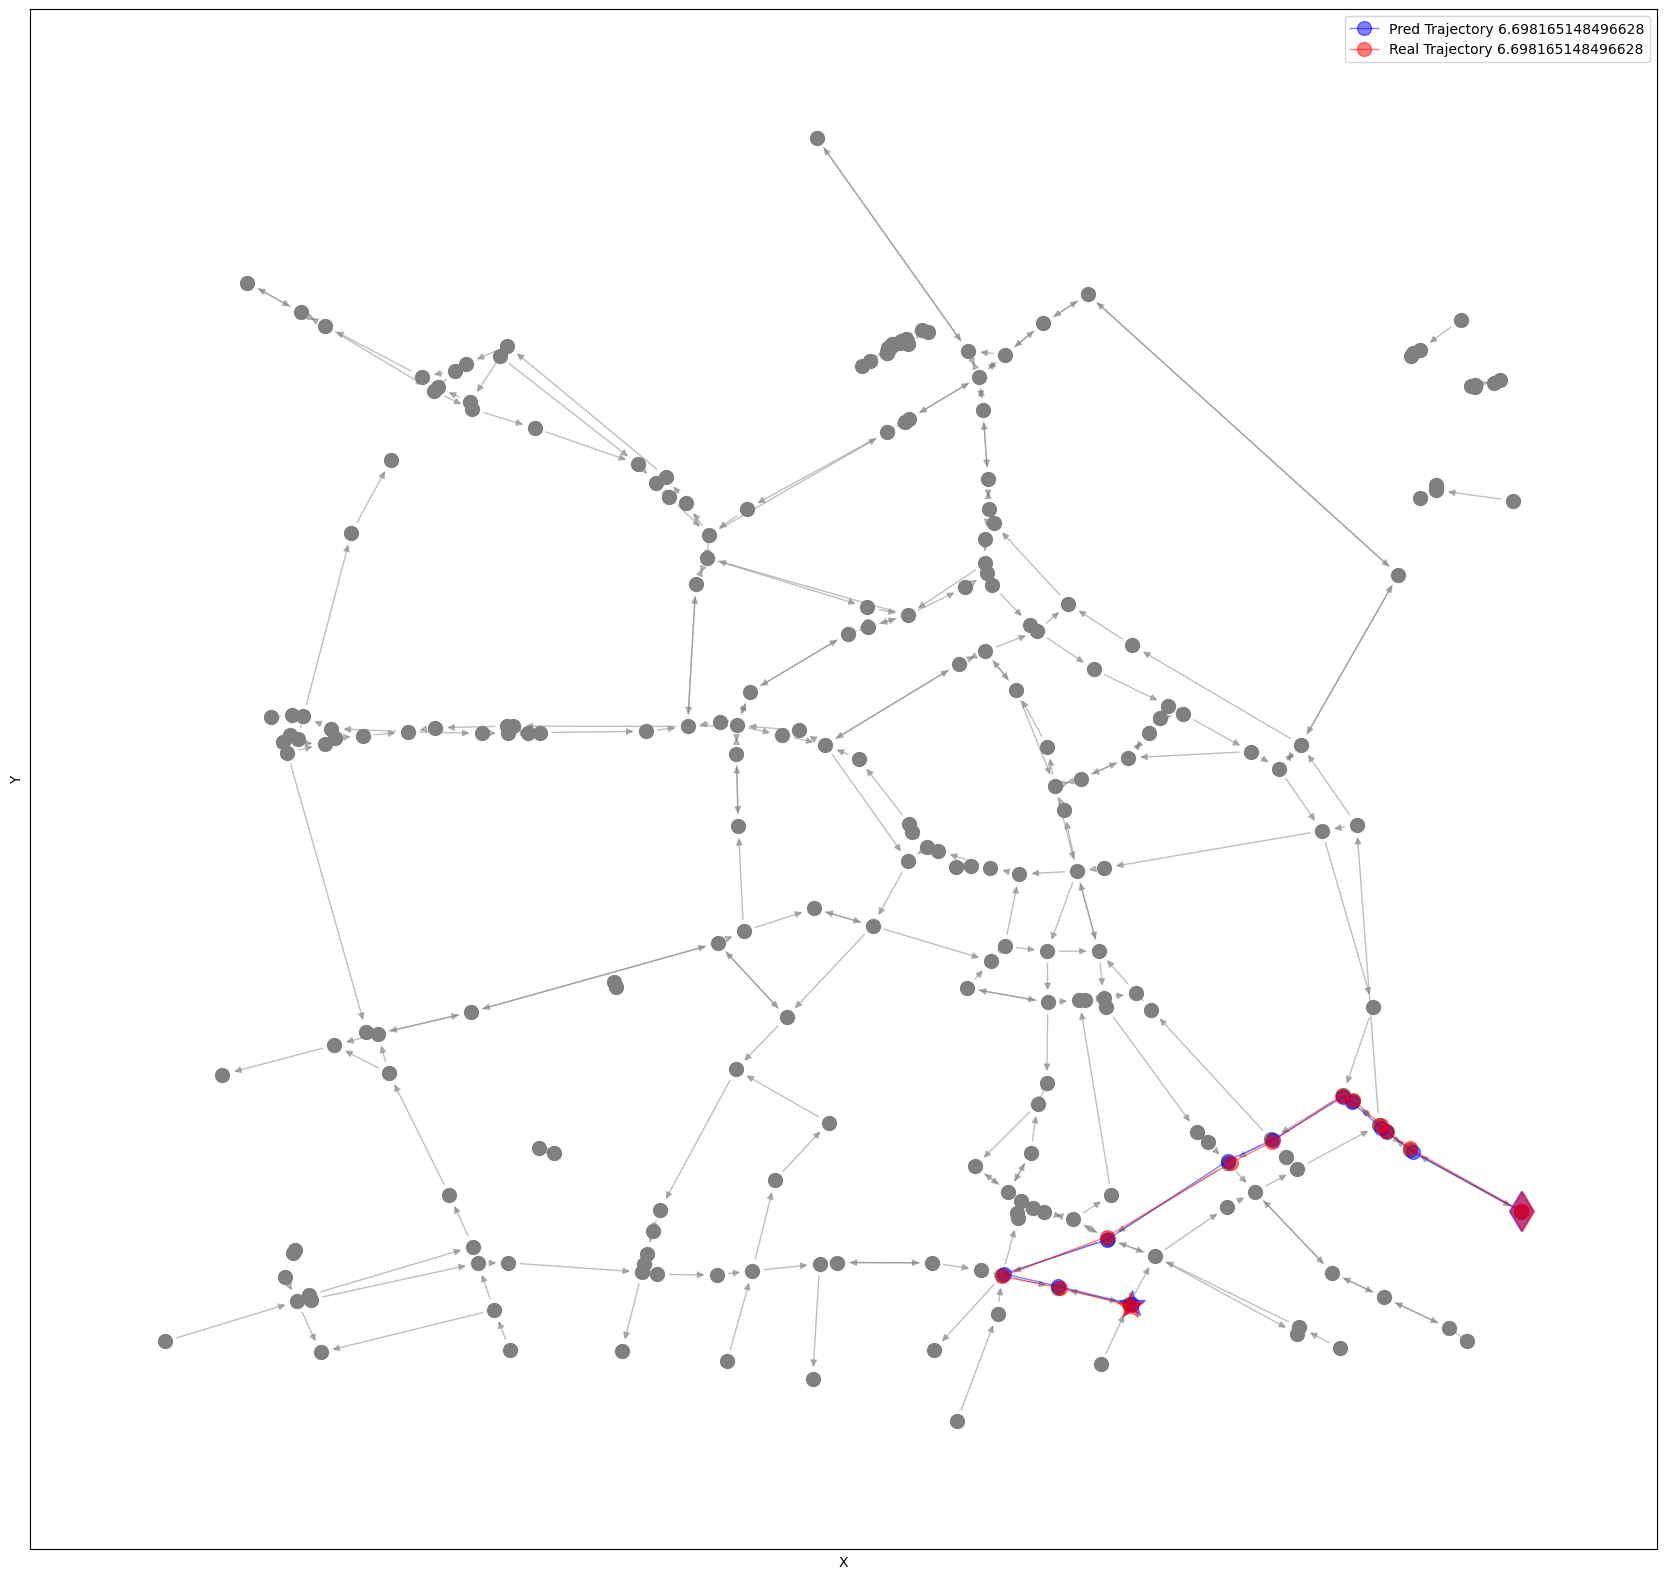

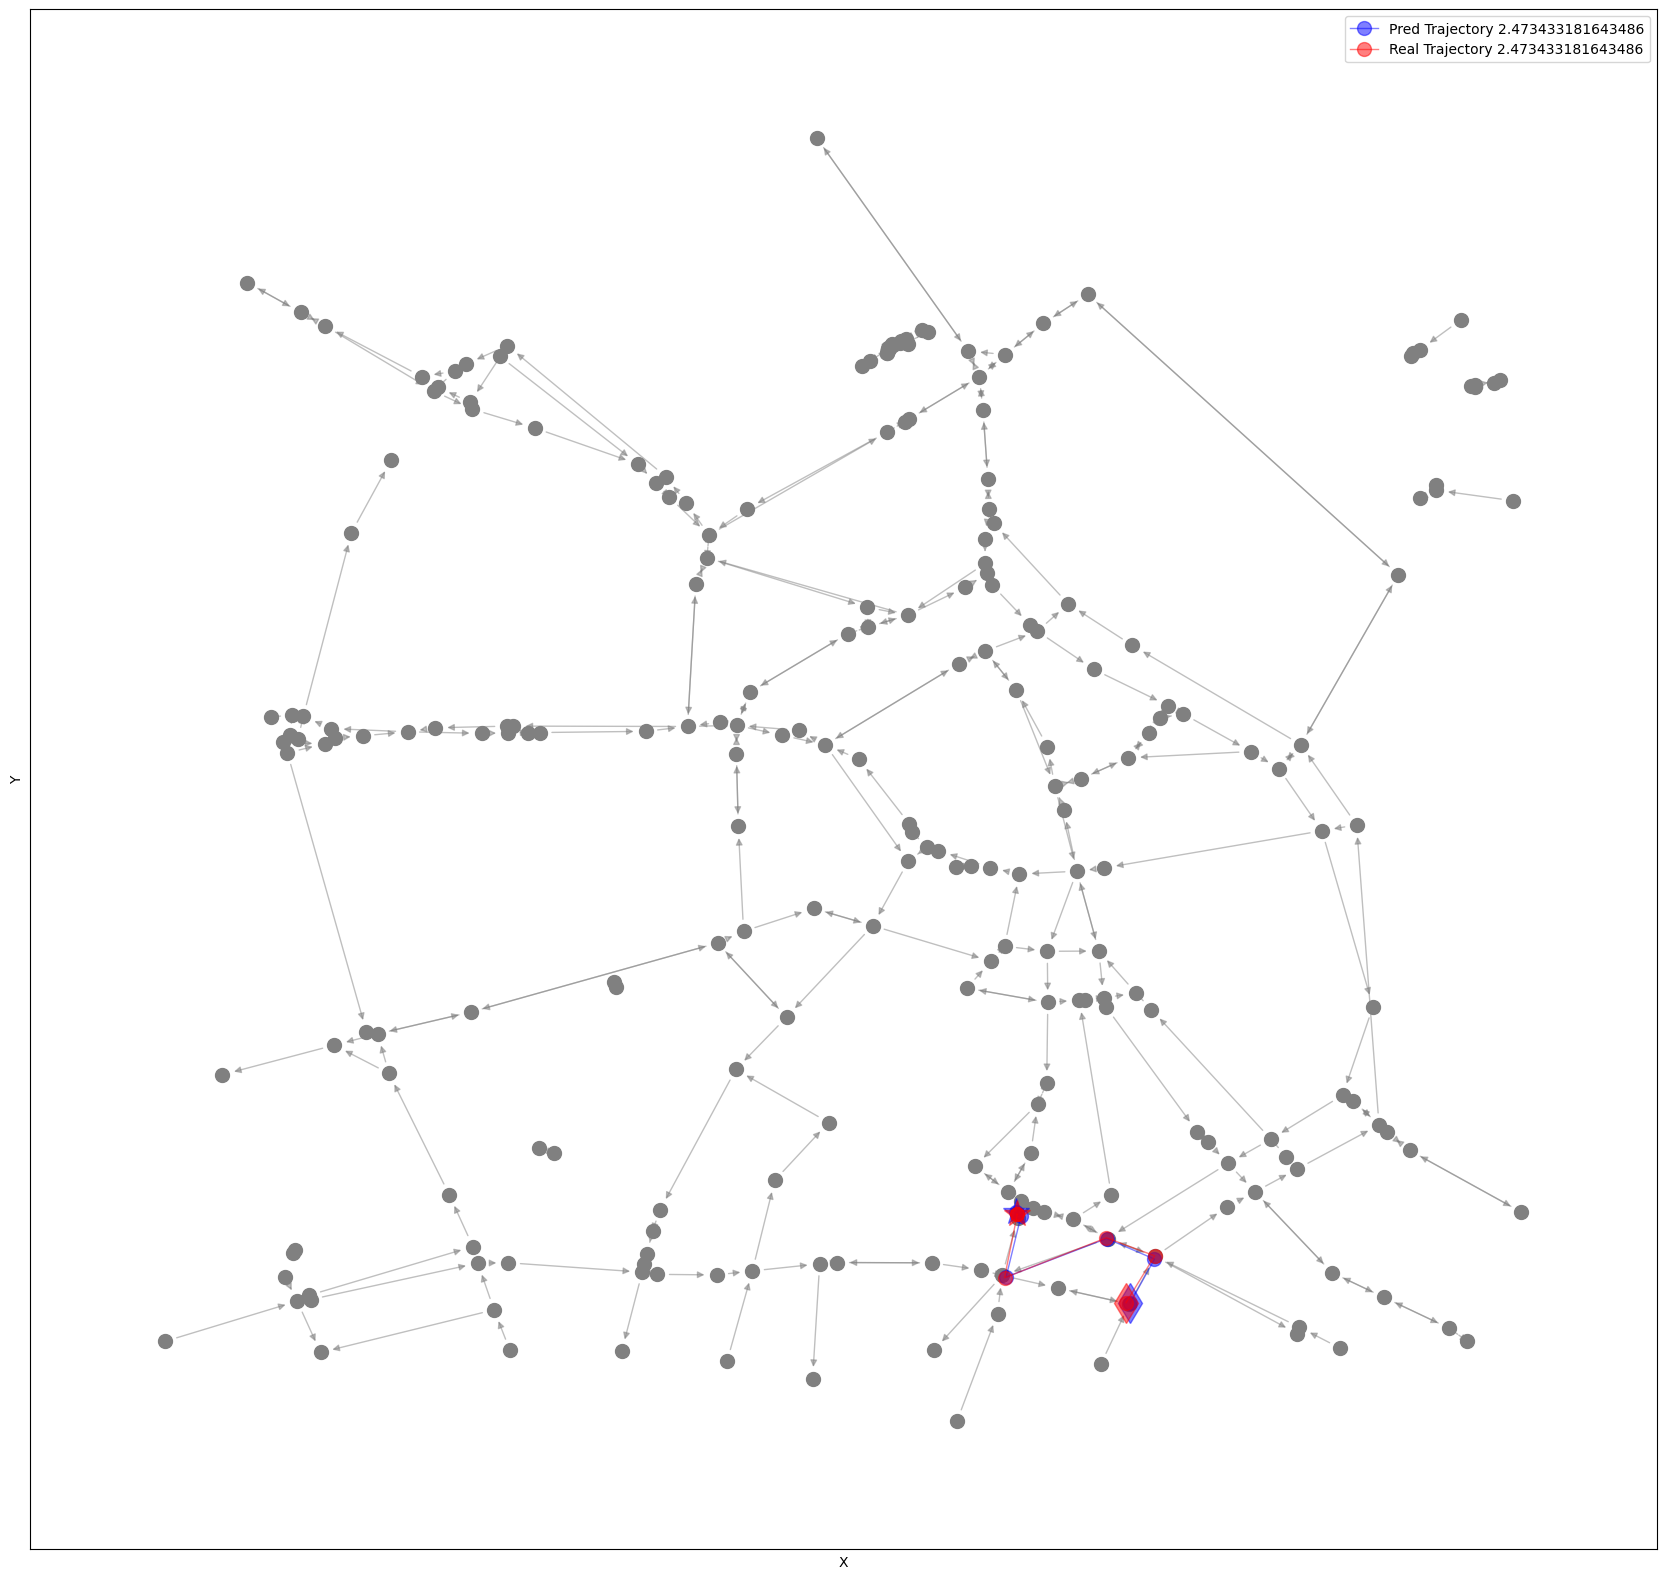

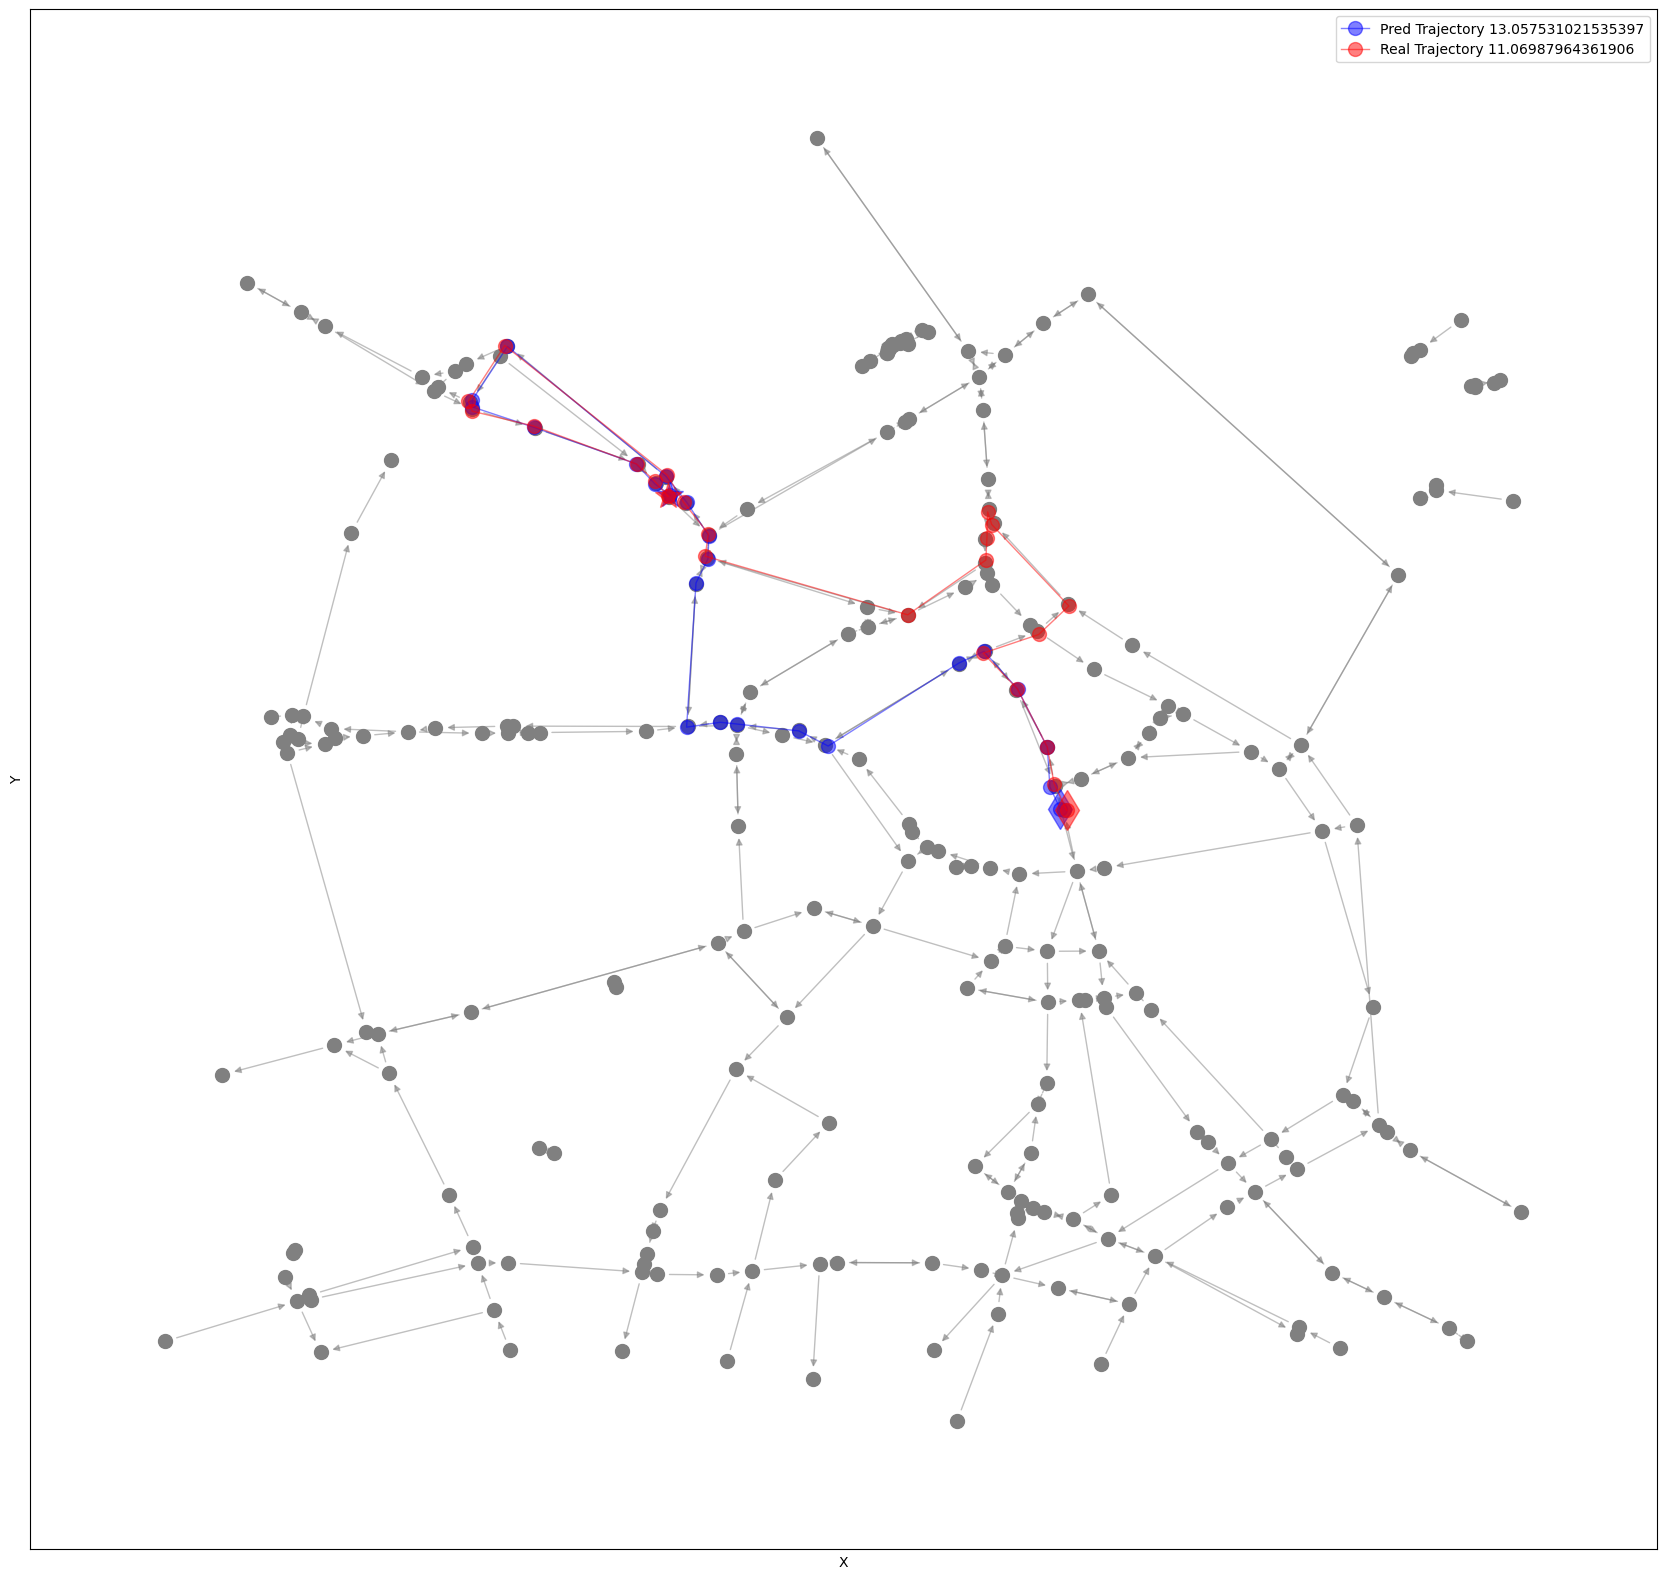

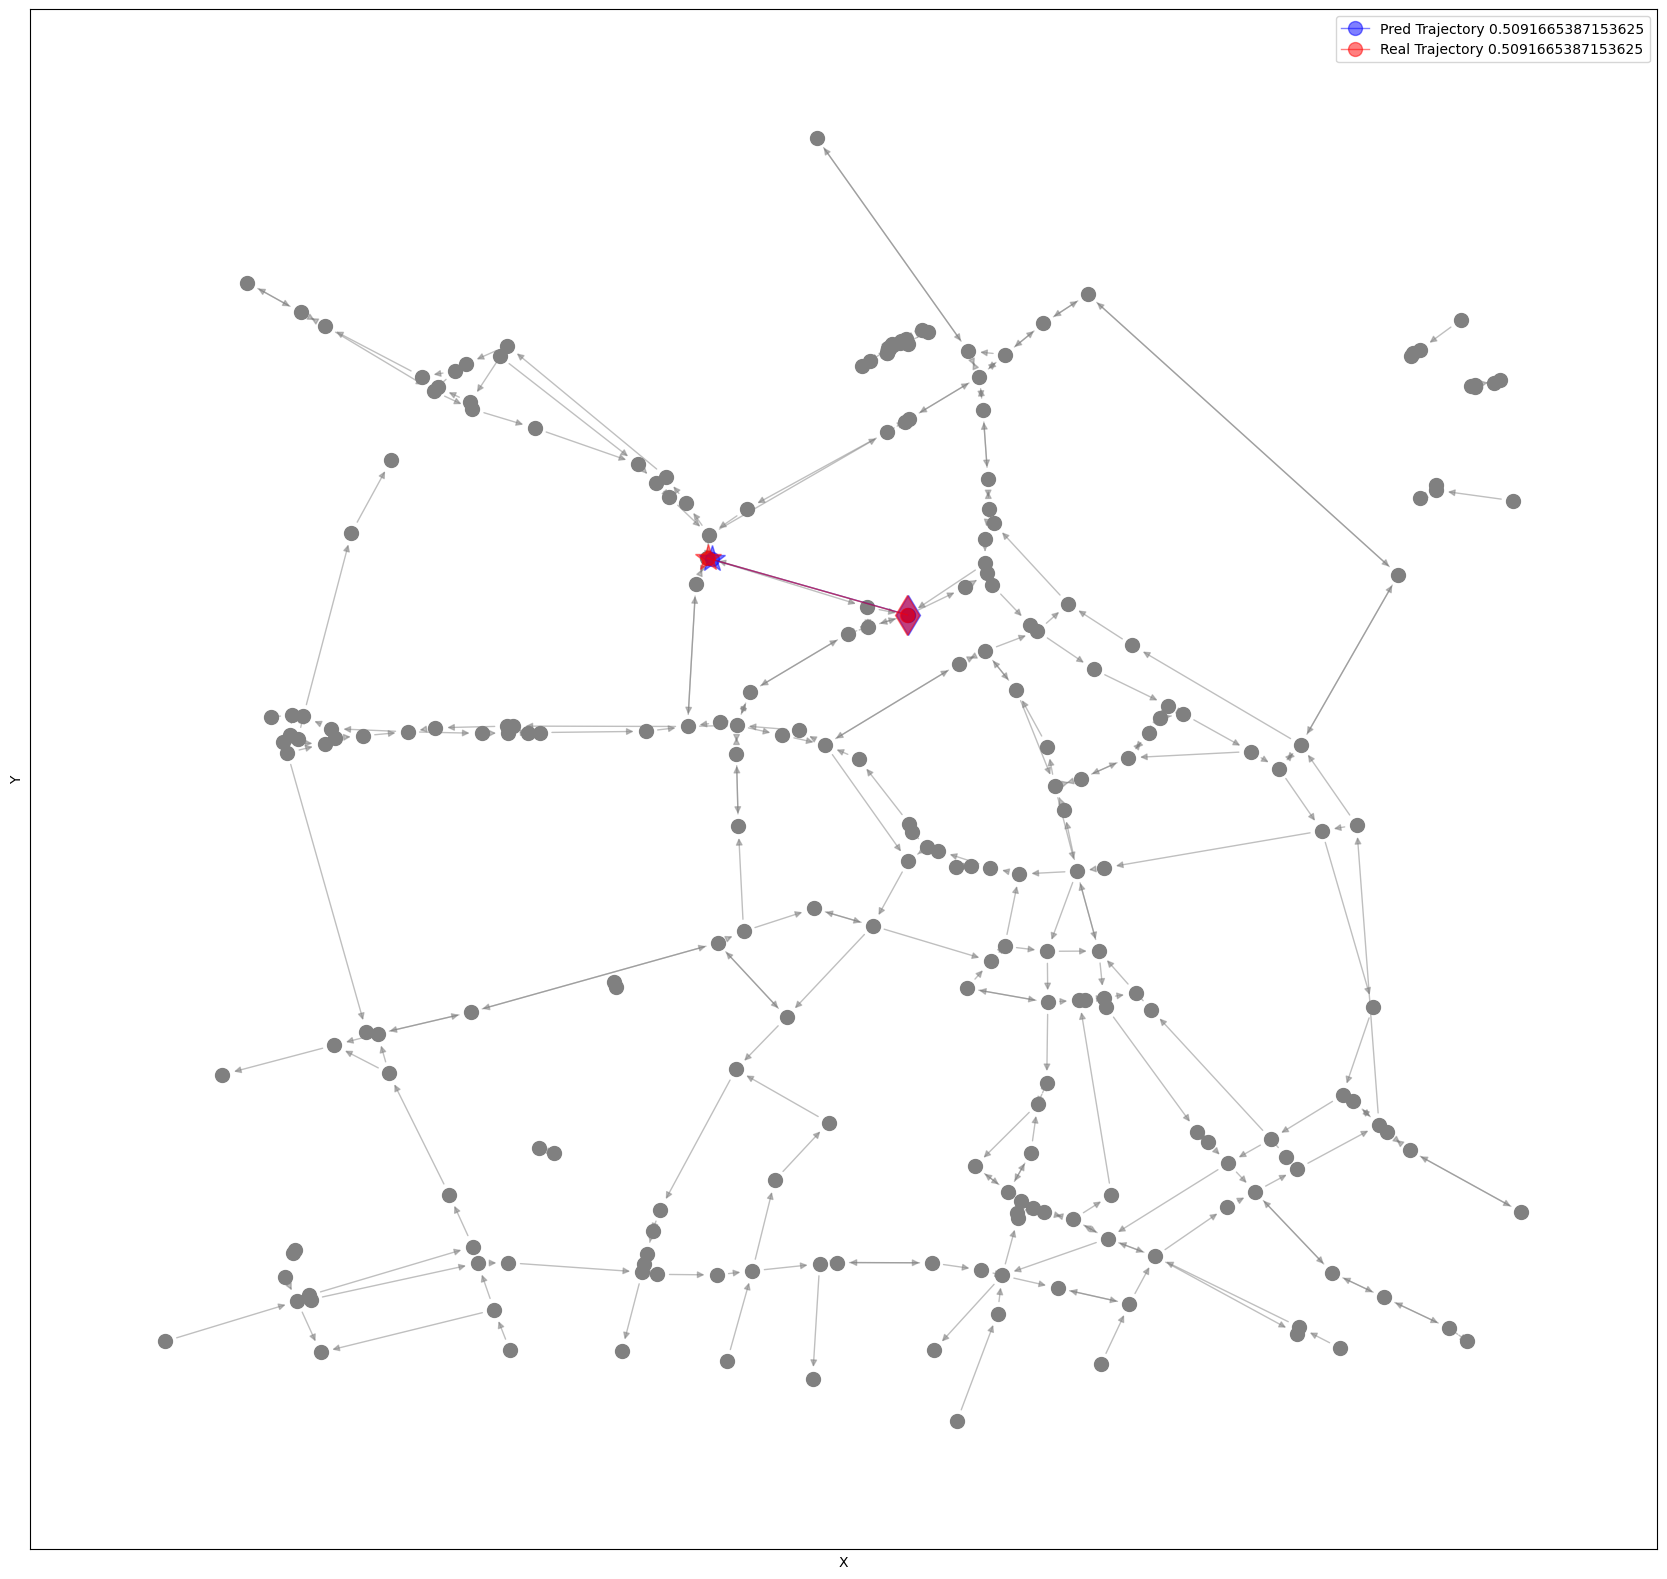

In [16]:
# plot the trajectory
from utils import plot_trajs, remove_special_token
from dataset import read_city

_, pos = read_city('boston')

fig_size = 20
plot_num = min(5, test_num)

for i in range(plot_num):
    fig, ax = plt.subplots(1, total_trajectories, figsize=((fig_size+1)*total_trajectories, fig_size))
    for j in range(total_trajectories):
        traj = predic_trajectory[i,j] # (block_size,)
        traj_ = test_trajectory[i,j] # (block_size,)
        traj = remove_special_token(traj)
        traj_ = remove_special_token(traj_)

        test_weight_adj = transfer_table_to_matrix(test_adj_table[i])
        G = transfer_graph(test_adj_table[i])
        if total_trajectories == 1:
            plot_trajs(ax, G, pos, test_weight_adj, traj, traj_, ground_truth=False)
        else:
            plot_trajs(ax[j], G, pos, test_weight_adj, traj, traj_, ground_truth=False)
    plt.show()
